In [18]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from functions import apply_otsu

Try grain size analysis to identify rocks in an image.

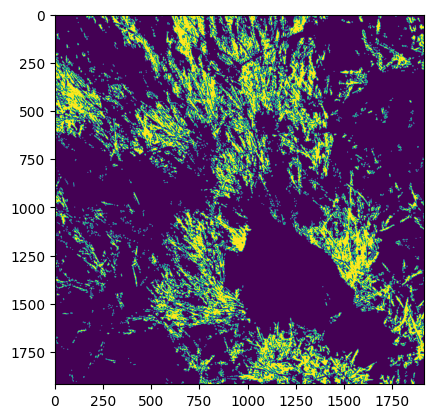

In [19]:
# Load in RGBVI image that contains rocks
img = cv2.imread('results/cropped_rgbvi_gray/image_25.jpg', 0)

# plt.hist(rgbvi_img.flatten(), bins = 100)

# Threshold it to only include plants
ret, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)


mask = thresh == 255
kernel = np.ones((3,3), np.uint8)
mask = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)


plt.imshow(mask)